In [5]:
import torch
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification, ViTFeatureExtractor
from PIL import Image
import pandas as pd
import os
from torchvision import datasets
from torch.utils.data import DataLoader
from PIL import Image

In [6]:
#Load ImageNet pre-trained ViT
model_name = 'google/vit-base-patch16-224-in21k' #Model version

model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels = 4,
    problem_type="multi_label_classification"
) 

# Feature extractor for preprocessing images
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [7]:
class ViTDataset(datasets.ImageFolder):
    def __getitem__(self, index):
        image, label = super().__getitem__(index)  # Load image and label
        image = feature_extractor(images=image, return_tensors="pt")["pixel_values"].squeeze(0)  # Apply feature extractor
        return image, label


# DATASET.

In [8]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/covid19-radiography-database


In [9]:
#Read dataset.
data_path = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID"

# List files inside the original dataset
files = os.listdir(data_path)
print("Files in dataset:", files)


Files in dataset: ['images', 'masks']


In [10]:
import shutil
import random
from pathlib import Path

# Define the dataset paths
DATASET_PATH = "//kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset"
OUTPUT_DIR = "/kaggle/working/covid_split"

TRAIN_DIR = os.path.join(OUTPUT_DIR, "train")
VAL_DIR = os.path.join(OUTPUT_DIR, "val")
TEST_DIR = os.path.join(OUTPUT_DIR, "test")

# Define class names (each folder contains "images" and "mask" subfolders)
CLASSES = ["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"]

# Function to create directories
def create_dirs():
    for split in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
        for cls in CLASSES:
            os.makedirs(os.path.join(split, cls), exist_ok=True)

create_dirs()

# Function to split and copy images
def split_data(source_folder, class_name, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    image_folder = os.path.join(source_folder, "images")  # Target "images" subfolder
    image_files = list(Path(image_folder).glob("*.png"))  # Get all image files
    
    random.shuffle(image_files)  # Shuffle for randomness
    
    train_count = int(len(image_files) * train_ratio)
    val_count = int(len(image_files) * val_ratio)
    
    train_files = image_files[:train_count]
    val_files = image_files[train_count:train_count + val_count]
    test_files = image_files[train_count + val_count:]

    # Copy images to train, val, and test folders
    for file in train_files:
        shutil.copy(file, os.path.join(TRAIN_DIR, class_name, file.name))
    
    for file in val_files:
        shutil.copy(file, os.path.join(VAL_DIR, class_name, file.name))
    
    for file in test_files:
        shutil.copy(file, os.path.join(TEST_DIR, class_name, file.name))

# Process each class folder
for cls in CLASSES:
    source_path = os.path.join(DATASET_PATH, cls)  # Main folder for each class
    split_data(source_path, cls)

# Verify the split
for split in ["train", "val", "test"]:
    for cls in CLASSES:
        path = os.path.join(OUTPUT_DIR, split, cls)
        print(f"{split}/{cls}: {len(os.listdir(path))} images")


train/COVID: 2531 images
train/Lung_Opacity: 4208 images
train/Normal: 7134 images
train/Viral Pneumonia: 941 images
val/COVID: 542 images
val/Lung_Opacity: 901 images
val/Normal: 1528 images
val/Viral Pneumonia: 201 images
test/COVID: 543 images
test/Lung_Opacity: 903 images
test/Normal: 1530 images
test/Viral Pneumonia: 203 images


Image 1 | Class: Lung_Opacity | Shape: (299, 299, 3)
Image 2 | Class: COVID | Shape: (299, 299, 3)
Image 3 | Class: Lung_Opacity | Shape: (299, 299, 3)
Image 4 | Class: Lung_Opacity | Shape: (299, 299, 3)
Image 5 | Class: Normal | Shape: (299, 299, 3)


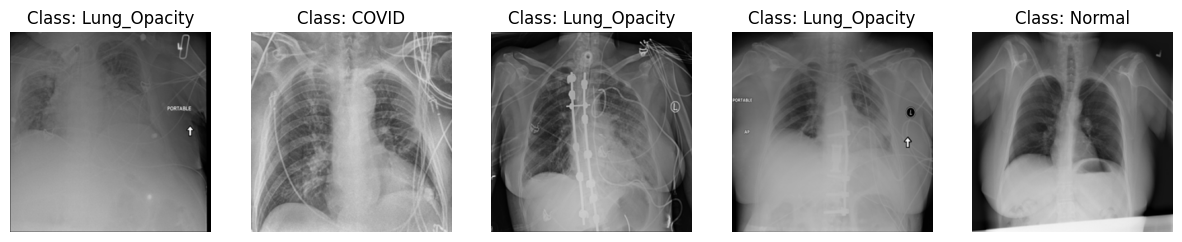

In [11]:
import matplotlib.pyplot as plt
import cv2
import random
from glob import glob

# Define dataset path (update with 'train', 'val', or 'test')
dataset_path = "/kaggle/working/covid_split/train"  # Change to 'val' or 'test' if needed

# Get all image file paths from subdirectories
image_files = glob(os.path.join(dataset_path, "*/*.png"))  # Adjust extension if needed

# Randomly select 5 images
num_images = 5
selected_images = random.sample(image_files, num_images)  # Random sampling

# Create plot
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i, img_path in enumerate(selected_images):
    img = cv2.imread(img_path)  # Read as grayscale
    class_name = os.path.basename(os.path.dirname(img_path))  # Extract class from folder name

    print(f"Image {i+1} | Class: {class_name} | Shape: {img.shape}")  # Print class & shape

    # Show image
    axes[i].imshow(img, cmap="gray")  # Use 'gray' colormap for grayscale images
    axes[i].set_title(f"Class: {class_name}")  # Show class as title
    axes[i].axis("off")

plt.show()

In [12]:
# Define dataset paths
train_dir = "/kaggle/working/covid_split/train"
val_dir = "/kaggle/working/covid_split/val"
test_dir = "/kaggle/working/covid_split/test"

# Load datasets
train_dataset = ViTDataset(root=train_dir)
val_dataset = ViTDataset(root=val_dir)
test_dataset = ViTDataset(root=test_dir)

# Define batch size
batch_size = 32

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Check batch shape
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}, Labels: {labels}")


Batch shape: torch.Size([32, 3, 224, 224]), Labels: tensor([2, 1, 2, 2, 0, 2, 0, 2, 0, 2, 2, 1, 0, 2, 0, 2, 2, 3, 1, 0, 2, 2, 2, 2,
        2, 2, 2, 1, 1, 0, 1, 1])


# TRAIN.

In [13]:
#Loss recording and plotting.
#ReciproCAM.
#Model saving.

In [14]:
def train(model, train_loader, optimizer, criterion, device, scheduler=None):
    total_correct = 0.0
    total_loss = 0.0
    batch_loss = 0.0
    batch_correct = 0.0

    model.train()
    for idx, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        output = model(inputs).logits  # Ensure you're using logits (if using HuggingFace model)
        
        # Calculate loss
        loss = criterion(output, labels)
        loss.backward()
        
        # Calculate accuracy
        correct = (output.argmax(dim=1) == labels).sum().item()
        
        # Accumulate total correct and total loss
        total_correct += correct
        total_loss += loss.item()

        # Batch statistics for logging
        batch_correct += correct
        batch_loss += loss.item()

        optimizer.step()

        if (idx + 1) % 100 == 0:
            # Print out the average loss and accuracy every 100 batches
            print(f"Batch {idx + 1}: Average Loss {batch_loss / 100:.4f} | Average Accuracy {batch_correct / (100 * len(labels)) * 100:.2f}%")
            batch_correct = 0.0
            batch_loss = 0.0

        # Update learning rate scheduler if provided
        if scheduler is not None:
            scheduler.step()
    
    # Return the average accuracy and loss for the entire dataset
    avg_accuracy = total_correct / len(train_loader.dataset)
    avg_loss = total_loss / len(train_loader)
    return avg_accuracy, avg_loss


In [15]:
LR = 2e-05
EPOCHS = 20

In [16]:
import torch.nn as nn
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.995)
device = "cuda"

In [17]:
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [18]:
def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_correct = 0.0
    total_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            
            logits = output.logits
            
            # Calculate loss
            loss = criterion(logits, labels)
            total_correct += (logits.argmax(dim=1) == labels).sum().item()
            total_loss += loss.item()

    accuracy = total_correct / len(test_loader.dataset)
    loss = total_loss / len(test_loader)
    
    return accuracy, loss


In [19]:
import matplotlib.pyplot as plt
from tqdm import tqdm

def run(model, train_loader, validation_loader, optimizer, criterion, device, scheduler=None):
    current_patience = 0
    previous_valid_loss = None
    best_valid_loss = None
    
    # Initialize lists to store the losses for plotting
    train_losses = []
    valid_losses = []

    for epoch in tqdm(range(EPOCHS)):
        print("==================================================")
        print(f"EPOCH {epoch + 1}")
        train_accuracy, train_loss = train(model, train_loader, optimizer, criterion, device, scheduler=None)
        print(f"[TRAIN] EPOCH {epoch + 1} - LOSS: {train_loss}, ACCURACY: {train_accuracy}")
        validation_accuracy, validation_loss = evaluate(model, validation_loader, criterion, device)
        print(f"[VALIDATE] EPOCH {epoch + 1} - LOSS: {validation_loss}, ACCURACY: {validation_accuracy}")
        print("==================================================")

        # Store the losses for plotting later
        train_losses.append(train_loss)
        valid_losses.append(validation_loss)

        # first iteration
        if best_valid_loss is None and previous_valid_loss is None:
            best_valid_loss = validation_loss
            model.save_pretrained('/kaggle/outputs/doctorViT')
            previous_valid_loss = validation_loss
            continue
        # early stopping
        if validation_loss >= previous_valid_loss:
            current_patience += 1
            if current_patience >= 5:
                print("Early Stop")
                break
            previous_valid_loss = validation_loss

        # save best model
        if validation_loss <= best_valid_loss:
            model.save_pretrained('/kaggle/outputs/doctorViT')
            best_valid_loss = validation_loss
            patience = 0

    # Plot the losses after training
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH 1
Batch 100: Average Loss 0.8027 | Average Accuracy 71.59%
Batch 200: Average Loss 0.4186 | Average Accuracy 88.56%
Batch 300: Average Loss 0.2955 | Average Accuracy 91.56%
Batch 400: Average Loss 0.2699 | Average Accuracy 92.50%
[TRAIN] EPOCH 1 - LOSS: 0.42048955784374387, ACCURACY: 0.8690427973538545
[VALIDATE] EPOCH 1 - LOSS: 0.22614570643752813, ACCURACY: 0.9312736443883984


  5%|▌         | 1/20 [09:24<2:58:37, 564.06s/it]

EPOCH 2
Batch 100: Average Loss 0.1867 | Average Accuracy 95.00%
Batch 200: Average Loss 0.1774 | Average Accuracy 95.00%
Batch 300: Average Loss 0.1730 | Average Accuracy 94.94%
Batch 400: Average Loss 0.1759 | Average Accuracy 94.75%
[TRAIN] EPOCH 2 - LOSS: 0.1768200141226885, ACCURACY: 0.9497772377480761
[VALIDATE] EPOCH 2 - LOSS: 0.2006250061839819, ACCURACY: 0.9306431273644389


 10%|█         | 2/20 [19:00<2:51:27, 571.50s/it]

EPOCH 3
Batch 100: Average Loss 0.1173 | Average Accuracy 97.06%
Batch 200: Average Loss 0.1268 | Average Accuracy 96.50%
Batch 300: Average Loss 0.1389 | Average Accuracy 95.88%
Batch 400: Average Loss 0.1332 | Average Accuracy 95.72%
[TRAIN] EPOCH 3 - LOSS: 0.12932395216954579, ACCURACY: 0.962265424598353
[VALIDATE] EPOCH 3 - LOSS: 0.17632959371432663, ACCURACY: 0.9391551071878941


 15%|█▌        | 3/20 [28:35<2:42:22, 573.07s/it]

EPOCH 4
Batch 100: Average Loss 0.0736 | Average Accuracy 98.34%
Batch 200: Average Loss 0.0824 | Average Accuracy 97.72%
Batch 300: Average Loss 0.1021 | Average Accuracy 97.06%
Batch 400: Average Loss 0.0827 | Average Accuracy 97.72%
[TRAIN] EPOCH 4 - LOSS: 0.08679451918144977, ACCURACY: 0.9763737005535305
[VALIDATE] EPOCH 4 - LOSS: 0.17105796647258104, ACCURACY: 0.9489281210592686


 20%|██        | 4/20 [38:11<2:33:06, 574.15s/it]

EPOCH 5
Batch 100: Average Loss 0.0529 | Average Accuracy 98.75%
Batch 200: Average Loss 0.0802 | Average Accuracy 97.91%
Batch 300: Average Loss 0.0757 | Average Accuracy 97.75%
Batch 400: Average Loss 0.0588 | Average Accuracy 98.53%
[TRAIN] EPOCH 5 - LOSS: 0.06602562091777958, ACCURACY: 0.9830565681112461


 25%|██▌       | 5/20 [47:46<2:23:35, 574.34s/it]

[VALIDATE] EPOCH 5 - LOSS: 0.17814912152476609, ACCURACY: 0.9470365699873896
EPOCH 6
Batch 100: Average Loss 0.0469 | Average Accuracy 99.00%
Batch 200: Average Loss 0.0502 | Average Accuracy 98.69%
Batch 300: Average Loss 0.0529 | Average Accuracy 98.59%
Batch 400: Average Loss 0.0560 | Average Accuracy 98.75%
[TRAIN] EPOCH 6 - LOSS: 0.051560659985385886, ACCURACY: 0.9869717834480897


 30%|███       | 6/20 [57:22<2:14:08, 574.87s/it]

[VALIDATE] EPOCH 6 - LOSS: 0.17339912067167462, ACCURACY: 0.9492433795712484
EPOCH 7
Batch 100: Average Loss 0.0406 | Average Accuracy 98.97%
Batch 200: Average Loss 0.0273 | Average Accuracy 99.53%
Batch 300: Average Loss 0.0348 | Average Accuracy 99.19%
Batch 400: Average Loss 0.0315 | Average Accuracy 99.31%
[TRAIN] EPOCH 7 - LOSS: 0.034171406848488885, ACCURACY: 0.9923045767517213
[VALIDATE] EPOCH 7 - LOSS: 0.16991102532017976, ACCURACY: 0.9514501891551072


 35%|███▌      | 7/20 [1:06:57<2:04:37, 575.19s/it]

EPOCH 8
Batch 100: Average Loss 0.0138 | Average Accuracy 99.78%
Batch 200: Average Loss 0.0214 | Average Accuracy 99.66%
Batch 300: Average Loss 0.0294 | Average Accuracy 99.31%
Batch 400: Average Loss 0.0212 | Average Accuracy 99.59%
[TRAIN] EPOCH 8 - LOSS: 0.021677912146528904, ACCURACY: 0.9956797623869312


 40%|████      | 8/20 [1:16:33<1:55:04, 575.37s/it]

[VALIDATE] EPOCH 8 - LOSS: 0.23279707543551922, ACCURACY: 0.9413619167717528
EPOCH 9
Batch 100: Average Loss 0.0273 | Average Accuracy 99.22%
Batch 200: Average Loss 0.0488 | Average Accuracy 98.62%
Batch 300: Average Loss 0.0298 | Average Accuracy 99.09%
Batch 400: Average Loss 0.0260 | Average Accuracy 99.25%
[TRAIN] EPOCH 9 - LOSS: 0.03215678301881234, ACCURACY: 0.9910895099230458


 45%|████▌     | 9/20 [1:26:08<1:45:26, 575.15s/it]

[VALIDATE] EPOCH 9 - LOSS: 0.18938542402582242, ACCURACY: 0.9482976040353089
EPOCH 10
Batch 100: Average Loss 0.0133 | Average Accuracy 99.72%
Batch 200: Average Loss 0.0166 | Average Accuracy 99.69%
Batch 300: Average Loss 0.0194 | Average Accuracy 99.41%
Batch 400: Average Loss 0.0100 | Average Accuracy 99.84%
[TRAIN] EPOCH 10 - LOSS: 0.01527660639934467, ACCURACY: 0.9964898069393817


 50%|█████     | 10/20 [1:35:44<1:35:54, 575.49s/it]

[VALIDATE] EPOCH 10 - LOSS: 0.19903210653923453, ACCURACY: 0.9527112232030265
EPOCH 11
Batch 100: Average Loss 0.0112 | Average Accuracy 99.78%
Batch 200: Average Loss 0.0134 | Average Accuracy 99.62%
Batch 300: Average Loss 0.0286 | Average Accuracy 99.12%
Batch 400: Average Loss 0.0239 | Average Accuracy 99.41%
[TRAIN] EPOCH 11 - LOSS: 0.019654083500674584, ACCURACY: 0.9945321992709599


 55%|█████▌    | 11/20 [1:45:19<1:26:18, 575.41s/it]

[VALIDATE] EPOCH 11 - LOSS: 0.21476407445734366, ACCURACY: 0.9404161412358134
EPOCH 12
Batch 100: Average Loss 0.0128 | Average Accuracy 99.50%
Batch 200: Average Loss 0.0178 | Average Accuracy 99.47%
Batch 300: Average Loss 0.0080 | Average Accuracy 99.81%
Batch 400: Average Loss 0.0260 | Average Accuracy 99.16%
[TRAIN] EPOCH 12 - LOSS: 0.0173985220727734, ACCURACY: 0.9945321992709599


 60%|██████    | 12/20 [1:54:55<1:16:43, 575.43s/it]

[VALIDATE] EPOCH 12 - LOSS: 0.2186470335931517, ACCURACY: 0.9476670870113493
EPOCH 13
Batch 100: Average Loss 0.0051 | Average Accuracy 99.91%
Batch 200: Average Loss 0.0073 | Average Accuracy 99.84%
Batch 300: Average Loss 0.0122 | Average Accuracy 99.75%
Batch 400: Average Loss 0.0169 | Average Accuracy 99.50%
[TRAIN] EPOCH 13 - LOSS: 0.010343203144087647, ACCURACY: 0.9975698663426489


 65%|██████▌   | 13/20 [2:04:30<1:07:07, 575.38s/it]

[VALIDATE] EPOCH 13 - LOSS: 0.2493869025958702, ACCURACY: 0.9438839848675914
EPOCH 14
Batch 100: Average Loss 0.0149 | Average Accuracy 99.59%
Batch 200: Average Loss 0.0206 | Average Accuracy 99.47%
Batch 300: Average Loss 0.0056 | Average Accuracy 99.88%
Batch 400: Average Loss 0.0319 | Average Accuracy 98.88%
[TRAIN] EPOCH 14 - LOSS: 0.017368870080784606, ACCURACY: 0.9949372215471851


 70%|███████   | 14/20 [2:14:06<57:33, 575.52s/it]  

[VALIDATE] EPOCH 14 - LOSS: 0.22015531675191596, ACCURACY: 0.9523959646910467
EPOCH 15
Batch 100: Average Loss 0.0083 | Average Accuracy 99.81%
Batch 200: Average Loss 0.0029 | Average Accuracy 99.97%
Batch 300: Average Loss 0.0096 | Average Accuracy 99.69%
Batch 400: Average Loss 0.0102 | Average Accuracy 99.62%
[TRAIN] EPOCH 15 - LOSS: 0.008548533529109578, ACCURACY: 0.9975023626299446


 75%|███████▌  | 15/20 [2:23:42<47:58, 575.79s/it]

[VALIDATE] EPOCH 15 - LOSS: 0.2394576844049152, ACCURACY: 0.9492433795712484
EPOCH 16
Batch 100: Average Loss 0.0178 | Average Accuracy 99.44%
Batch 200: Average Loss 0.0105 | Average Accuracy 99.66%
Batch 300: Average Loss 0.0165 | Average Accuracy 99.44%
Batch 400: Average Loss 0.0056 | Average Accuracy 99.91%
[TRAIN] EPOCH 16 - LOSS: 0.013648841707976273, ACCURACY: 0.9956797623869312


 80%|████████  | 16/20 [2:33:19<38:23, 575.99s/it]

[VALIDATE] EPOCH 16 - LOSS: 0.2704428303911118, ACCURACY: 0.9407313997477932
EPOCH 17
Batch 100: Average Loss 0.0074 | Average Accuracy 99.81%
Batch 200: Average Loss 0.0034 | Average Accuracy 99.94%
Batch 300: Average Loss 0.0043 | Average Accuracy 99.88%
Batch 400: Average Loss 0.0132 | Average Accuracy 99.75%
[TRAIN] EPOCH 17 - LOSS: 0.006734171244753303, ACCURACY: 0.9985149183205076


 85%|████████▌ | 17/20 [2:42:54<28:47, 575.78s/it]

[VALIDATE] EPOCH 17 - LOSS: 0.21891031504434066, ACCURACY: 0.9546027742749055
EPOCH 18
Batch 100: Average Loss 0.0023 | Average Accuracy 99.94%
Batch 200: Average Loss 0.0031 | Average Accuracy 99.94%
Batch 300: Average Loss 0.0013 | Average Accuracy 100.00%
Batch 400: Average Loss 0.0014 | Average Accuracy 99.97%
[TRAIN] EPOCH 18 - LOSS: 0.0019405059592866743, ACCURACY: 0.9995949777237748


 90%|█████████ | 18/20 [2:52:29<19:11, 575.66s/it]

[VALIDATE] EPOCH 18 - LOSS: 0.2591932327928953, ACCURACY: 0.9495586380832283
EPOCH 19
Batch 100: Average Loss 0.0010 | Average Accuracy 100.00%
Batch 200: Average Loss 0.0008 | Average Accuracy 100.00%
Batch 300: Average Loss 0.0007 | Average Accuracy 100.00%
Batch 400: Average Loss 0.0007 | Average Accuracy 100.00%
[TRAIN] EPOCH 19 - LOSS: 0.0007712769907442591, ACCURACY: 1.0


 95%|█████████▌| 19/20 [3:02:03<09:35, 575.14s/it]

[VALIDATE] EPOCH 19 - LOSS: 0.26312157992244467, ACCURACY: 0.9520807061790668
EPOCH 20
Batch 100: Average Loss 0.0006 | Average Accuracy 100.00%
Batch 200: Average Loss 0.0006 | Average Accuracy 100.00%
Batch 300: Average Loss 0.0006 | Average Accuracy 100.00%
Batch 400: Average Loss 0.0006 | Average Accuracy 100.00%
[TRAIN] EPOCH 20 - LOSS: 0.0005793435615738834, ACCURACY: 1.0


100%|██████████| 20/20 [3:11:39<00:00, 574.95s/it]

[VALIDATE] EPOCH 20 - LOSS: 0.27116236162109997, ACCURACY: 0.9514501891551072


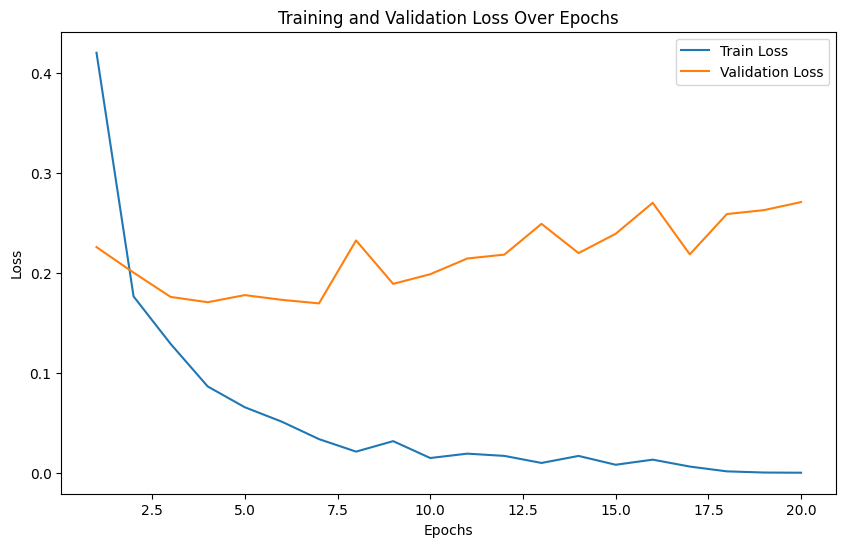

In [20]:
run(model, train_loader, val_loader, optimizer, criterion, device, scheduler)

In [24]:
def predict(model, test_loader, criterion, device):
    total_loss = 0.0
    preds = list()
    targets = list()
    
    model.eval()
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # forward
        output = model(inputs)
        
        output = output.logits
        
        # calculate loss
        loss = criterion(output, labels)
        preds += torch.topk(output, 1)[1].cpu().detach().numpy().tolist()
        targets += labels.cpu().detach().numpy().tolist()
        total_loss += loss.item()
        
    return total_loss/len(test_loader), preds, targets


In [25]:
test_loss, preds, targets = predict(model, test_loader, criterion, device)

In [23]:
test_loss

0.28634170196717607